Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-1-bc96798bb2fd>:73: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather["TEMP_lag1"] = weather["TEMP_lag1"].fillna(method="bfill")
<ipython-input-1-bc96798bb2fd>:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather["AIRP_lag1"] = weather["AIRP_lag1"].fillna(method="bfill")
<ipython-input-1-bc96798bb2fd>:75: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather["HUMI_lag1"] = weather["HUMI_lag1"].fillna(method="bfill")
<ipython-input-1-bc96798bb2fd>:76: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather["SOLA_lag1"] = weather["SOLA_lag1"].fillna(method="bfill")
<ipython-input-1-bc96798bb2fd>:83: FutureWarning: Se

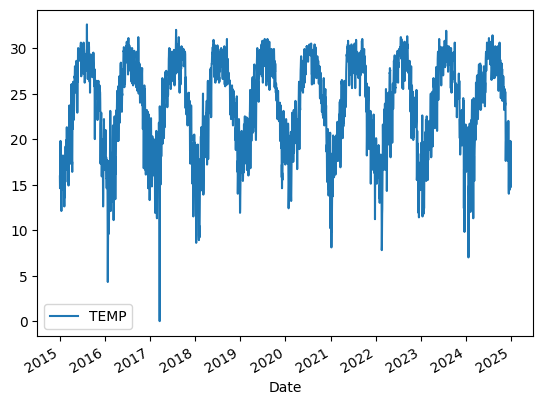

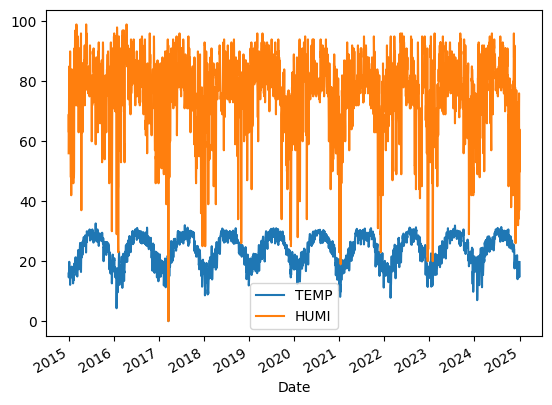

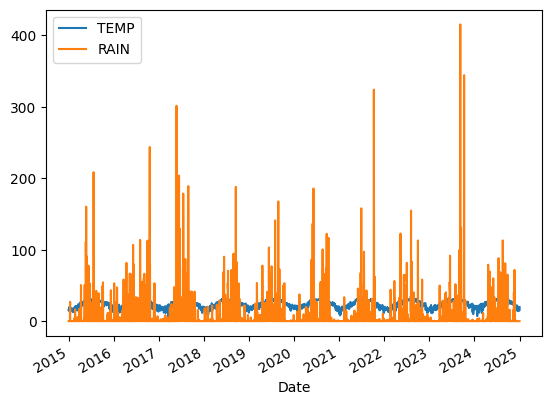

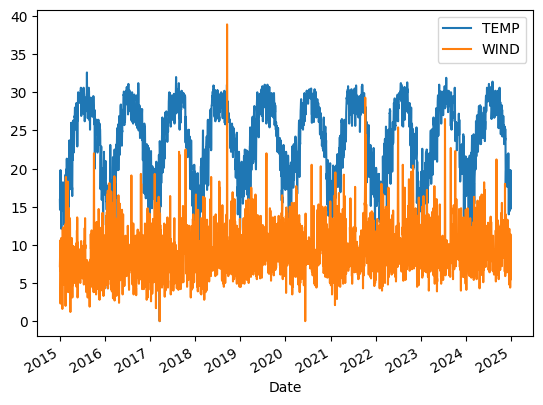

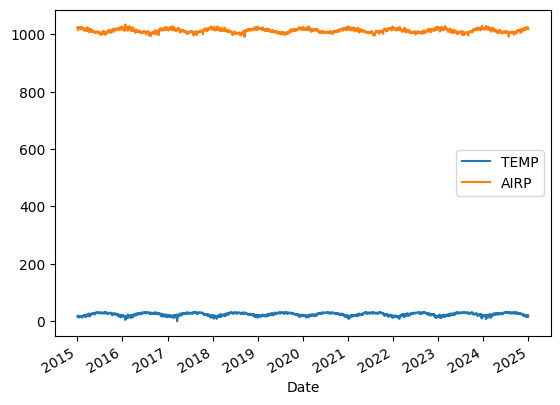

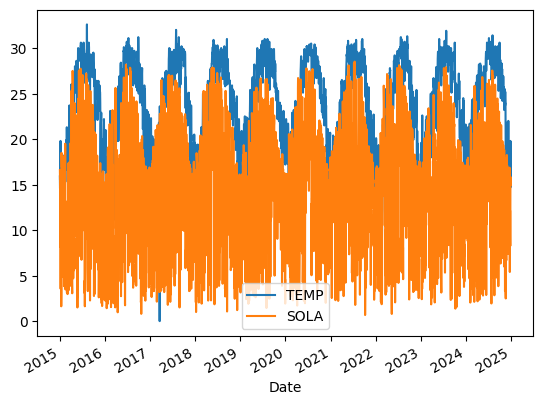

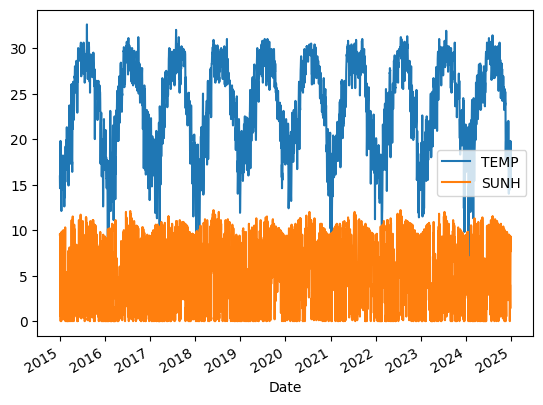

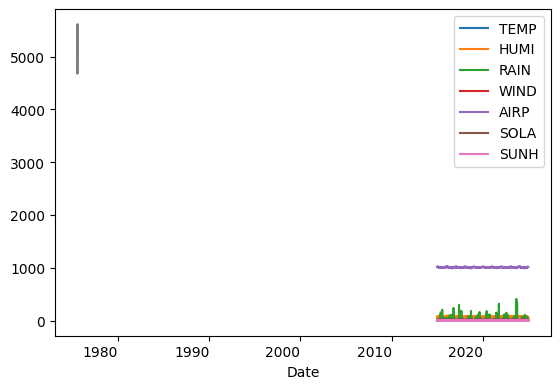

In [1]:
# -*- coding: utf-8 -*-
"""WeatherPredictionHK.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1Z_DdI7ED_0NVDZOm8o4M8VRpefTWUUZr
"""
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
weather = pd.read_csv('/content/drive/MyDrive/hkdailyweather.csv', index_col="Date") ## import data


"""TEMP = Mean Temperature (°C) - King's Park
HUMI = Mean Relative Humidity (%) - King's Park
RAIN = Total Rainfall (mm) - King's Park
WIND = Mean Wind Speed (km/h) - King's Park
AIRP = Daily Mean Pressure (hPa) at the Hong Kong Observatory
SOLA = Global Solar Radiation (MJ/m²) - King's Park
SUNH = Total Bright Sunshine (hours) - King's Park
"""

weather["TEMP"].value_counts()  ## To check the count of each data point
weather["HUMI"].value_counts()  ## if too little count, may not be useful or relevant
weather["SUNH"].value_counts()

"""If value is missing, we may need to fill back data, since ML does not work well with missing value. A forward fill approach or depending situation, fill the most likely data"""

weather.dtypes # check data type, must need be numerical

weather = weather.apply(pd.to_numeric, errors='coerce').astype(float) # convert all to float type

weather.dtypes

weather.apply(pd.isnull).sum()/weather.shape[0] ## data cleaning : look for null value, 0 mean all value exist

weather["TEMP"] = weather["TEMP"].fillna(0)   # fill in all null value
weather["HUMI"] = weather["HUMI"].fillna(0)
weather["RAIN"] = weather["RAIN"].fillna(0)
weather["WIND"] = weather["WIND"].fillna(0)

weather.apply(pd.isnull).sum()/weather.shape[0] ## data cleaning : look for null value, 0 mean all value exist

weather.index # check data type, convert to data time index using pandas function

weather.index = pd.to_datetime(weather.index) # convert to data time index using pandas function

weather.index

weather[["TEMP"]].plot()  # data visualisation

weather[["TEMP","HUMI"]].plot()
weather[["TEMP","RAIN"]].plot()
weather[["TEMP","WIND"]].plot()
weather[["TEMP","AIRP"]].plot()
weather[["TEMP","SOLA"]].plot()
weather[["TEMP","SUNH"]].plot()

weather[["TEMP","HUMI","RAIN","WIND","AIRP","SOLA","SUNH"]].plot()

weather.groupby(weather.index.year).sum() # Data of each year

weather.groupby(weather.index.year).apply(lambda x: x["SOLA"].sum()).plot() # Data of each year

# add lag function
weather["TEMP_lag1"] = weather["TEMP"].shift(1)
weather["AIRP_lag1"] = weather["AIRP"].shift(1)
weather["HUMI_lag1"] = weather["HUMI"].shift(1)
weather["SOLA_lag1"] = weather["SOLA"].shift(1)

weather["TEMP_lag1"] = weather["TEMP_lag1"].fillna(method="bfill")
weather["AIRP_lag1"] = weather["AIRP_lag1"].fillna(method="bfill")
weather["HUMI_lag1"] = weather["HUMI_lag1"].fillna(method="bfill")
weather["SOLA_lag1"] = weather["SOLA_lag1"].fillna(method="bfill")

# add rolling average
window_size = 7 # 7 day rolling average

weather["TEMP_rolling_mean"] = weather["TEMP"].rolling(window=window_size, min_periods=1).mean()
weather["TEMP_rolling_std"] = weather["TEMP"].rolling(window=window_size, min_periods=1).std()
weather["TEMP_rolling_mean"] = weather["TEMP_rolling_mean"].fillna(method="bfill")
weather["TEMP_rolling_std"] = weather["TEMP_rolling_std"].fillna(method="bfill")

# add combine features
weather["SOLA_SUNH"] = weather["SOLA"] * weather["SUNH"]  # Effective solar energy
weather["SOLA_SUNH"] = weather["SOLA_SUNH"].fillna(method="ffill")

# difference features
# change in air pressure may imply temperature change
weather["AIRP_diff"] = weather["AIRP"].diff()
weather["AIRP_diff"] = weather["AIRP_diff"].fillna(method="bfill")

weather["target"] = weather.shift(-1)["TEMP"] # To predict the weather tmr

weather = weather.iloc[:-1,:].copy()  # remove the last row

from sklearn.linear_model import Lasso  # Lasso regression
reg = Lasso(alpha=0.1)                   # alpha = penalty, higher values increase regularization

predictors = ["TEMP", "HUMI", "RAIN", "WIND", "AIRP", "SOLA", "SUNH", "TEMP_lag1", "AIRP_lag1", "HUMI_lag1", "SOLA_lag1","TEMP_rolling_mean","TEMP_rolling_std", "SOLA_SUNH","AIRP_diff"]

train = weather.loc[:"2020-12-31"]
test = weather.loc["2021-01-01":]

reg.fit(train[predictors], train["target"]) # fit model to data set

predictions = reg.predict(test[predictors])


In [2]:
from sklearn.metrics import mean_squared_error

mean_squared_error(test["target"], predictions) # mean squared error

# lasso
# 1.996151712582198 with lag features + rolling average + combine feature + difference feature

1.996151712582198

,actual,predictions,diff
Date,,,
2024-01-22,7.0,15.110653,8.110653
2021-01-07,8.1,14.941825,6.841825
2022-10-17,20.1,26.318758,6.218758
2024-02-29,12.4,18.548424,6.148424
2023-12-16,12.4,18.447022,6.047022
2023-12-15,18.0,24.015479,6.015479
2022-11-30,15.5,21.513394,6.013394
2023-01-15,11.5,17.489832,5.989832
2022-03-22,17.1,22.657667,5.557667


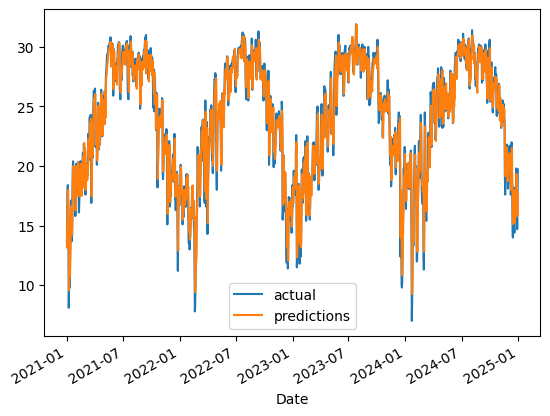

In [3]:
combined = pd.concat([test["target"], pd.Series(predictions, index=test.index)], axis=1)
combined.columns = ["actual", "predictions"]

combined.plot()

reg.coef_
# Check which coefficients are zero to understand feature selection

weather.corr()["target"]  # correlation

combined["diff"] = (combined["actual"] - combined["predictions"]).abs()

combined.sort_values("diff", ascending=False).head(10)